In [33]:
import  pandas as pd
import  numpy as np

prices = pd.read_csv("../data/raw/eurusd_daily.csv", parse_dates=["date"])
events = pd.read_csv("../data/reference/us_cpi_events.csv", parse_dates=["event_date"])

prices = prices.sort_values("date").reset_index(drop=True)
events = events.sort_values("event_date").reset_index(drop=True)

prices.head(), events.head()

(        date      open      high       low     close  adj_close  volume
 0 2015-01-01  1.209863  1.209863  1.209863  1.209863   1.209863       0
 1 2015-01-02  1.208868  1.208956  1.201080  1.208941   1.208941       0
 2 2015-01-05  1.195500  1.197590  1.188909  1.194643   1.194643       0
 3 2015-01-06  1.193830  1.197000  1.188693  1.193902   1.193902       0
 4 2015-01-07  1.187479  1.190000  1.180401  1.187536   1.187536       0,
   event_date event_name               source
 0 2015-01-01     US CPI  FRED (CPIAUCSL CSV)
 1 2015-02-01     US CPI  FRED (CPIAUCSL CSV)
 2 2015-03-01     US CPI  FRED (CPIAUCSL CSV)
 3 2015-04-01     US CPI  FRED (CPIAUCSL CSV)
 4 2015-05-01     US CPI  FRED (CPIAUCSL CSV))

In [35]:
# Daily Log Returns
prices["log_return"] = np.log(prices["close"]).diff()

# 20-trading-day rolling annualized volatility
prices["vol_20d"] = prices["log_return"].rolling(20).std() * np.sqrt(252)

prices.tail()

,date,open,high,low,close,adj_close,volume,log_return,vol_20d
2857,2025-12-23,1.176443,1.180359,1.176429,1.176595,1.176595,0,0.004929,0.037175
2858,2025-12-24,1.179565,1.180916,1.177426,1.179551,1.179551,0,0.002509,0.036099
2859,2025-12-26,1.178384,1.179941,1.176304,1.178536,1.178536,0,-0.000861,0.035655
2860,2025-12-29,1.177496,1.178856,1.175406,1.177274,1.177274,0,-0.001072,0.036106
2861,2025-12-30,1.177302,1.178134,1.174619,1.177288,1.177288,0,0.000012,0.036137


In [36]:
# Create a DataFrame of Trading Dates
trading_dates = prices[["date"]].copy()

# For Each event_date, find the next available trading date
events_aligned = pd.merge_asof(
    events.sort_values("event_date"),
    trading_dates.sort_values("date"),
    left_on = "event_date",
    right_on = "date",
    direction = "forward"
)

events_aligned = events_aligned.rename(columns={"date": "event_trading_date"})
events_aligned.head(10)

,event_date,event_name,source,event_trading_date
0,2015-01-01,US CPI,FRED (CPIAUCSL CSV),2015-01-01
1,2015-02-01,US CPI,FRED (CPIAUCSL CSV),2015-02-02
2,2015-03-01,US CPI,FRED (CPIAUCSL CSV),2015-03-02
3,2015-04-01,US CPI,FRED (CPIAUCSL CSV),2015-04-01
4,2015-05-01,US CPI,FRED (CPIAUCSL CSV),2015-05-01
5,2015-06-01,US CPI,FRED (CPIAUCSL CSV),2015-06-01
6,2015-07-01,US CPI,FRED (CPIAUCSL CSV),2015-07-01
7,2015-08-01,US CPI,FRED (CPIAUCSL CSV),2015-08-03
8,2015-09-01,US CPI,FRED (CPIAUCSL CSV),2015-09-01
9,2015-10-01,US CPI,FRED (CPIAUCSL CSV),2015-10-01


In [37]:
WINDOW = 5 # Trading Days Before/After Event

prices2 = prices.copy()
prices2["t_index"] = np.arange(len(prices2)) # Index for Trading-day offsets
prices_idx = prices2.set_index("date")

rows = []

for _, row in events_aligned.iterrows():
    event_day = row["event_trading_date"]
    if pd.isna(event_day) or event_day not in prices_idx.index:
        continue

    base_i = int(prices_idx.loc[event_day, "t_index"])

    for k in range(-WINDOW, WINDOW + 1):
        i = base_i + k
        if 0 <= i < len(prices2):
            rows.append({
                "event_date": row["event_date"],
                "event_trading_date": event_day,
                "event_day": k,
                "date": prices2.loc[i, "date"],
                "log_return": prices2.loc[i, "log_return"],
                "vol_20d": prices2.loc[i, "vol_20d"]
            })
event_panel = pd.DataFrame(rows)
event_panel.head(15)

,event_date,event_trading_date,event_day,date,log_return,vol_20d
0,2015-01-01,2015-01-01,0,2015-01-01,NaN,NaN
1,2015-01-01,2015-01-01,1,2015-01-02,-0.000762,NaN
2,2015-01-01,2015-01-01,2,2015-01-05,-0.011897,NaN
3,2015-01-01,2015-01-01,3,2015-01-06,-0.000621,NaN
4,2015-01-01,2015-01-01,4,2015-01-07,-0.005346,NaN
5,2015-01-01,2015-01-01,5,2015-01-08,-0.003320,NaN
6,2015-02-01,2015-02-02,-5,2015-01-26,-0.019696,NaN
7,2015-02-01,2015-02-02,-4,2015-01-27,0.010929,NaN
8,2015-02-01,2015-02-02,-3,2015-01-28,0.010584,NaN
9,2015-02-01,2015-02-02,-2,2015-01-29,-0.007587,0.141303


In [38]:
avg = (
    event_panel.groupby("event_day")[["log_return", "vol_20d"]].mean().reset_index()
)
avg

,event_day,log_return,vol_20d
0,-5,-0.000255,0.074665
1,-4,0.000512,0.074409
2,-3,-0.000628,0.074241
3,-2,-0.000420,0.074549
4,-1,0.001001,0.074799
5,0,-0.000747,0.074410
6,1,0.000498,0.073974
7,2,-0.000298,0.073947
8,3,0.000757,0.075181
9,4,0.000242,0.075204


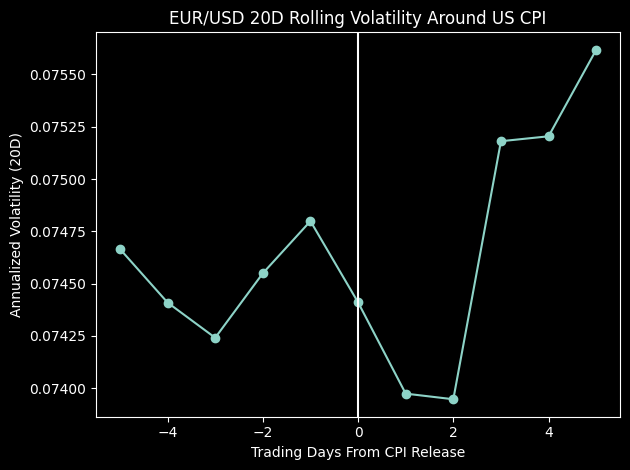

In [39]:
import matplotlib.pyplot as plt
import os

FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Avg Log Return Around Events
plt.figure()
plt.plot(avg["event_day"], avg["log_return"], marker="o")
plt.axvline(0)
plt.title("EUR/USD Average Log Return Around US CPI (Event Window)")
plt.xlabel("Trading Days From CPI Release")
plt.ylabel("Average Log Return")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/01_avg_return_cpi_window.png", dpi = 200)
plt.show()

# Avg Volatility Around Events
plt.figure()
plt.plot(avg["event_day"], avg["vol_20d"], marker="o")
plt.axvline(0)
plt.title("EUR/USD 20D Rolling Volatility Around US CPI")
plt.xlabel("Trading Days From CPI Release")
plt.ylabel("Annualized Volatility (20D)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/02_volatility_cpi_window.png", dpi = 200)
plt.show()

In [40]:
summary = avg.copy()
summary.loc[summary["event_day"] == 0, "label"] = "Event Day (0)"
summary.loc[summary["event_day"] == 1, "label"] = "Day +1"
summary.loc[summary["event_day"] == -1, "label"] = "Day -1"

summary[summary["event_day"].isin([-1,0,1])][["event_day", "label","log_return", "vol_20d"]]

,event_day,label,log_return,vol_20d
4,-1,Day -1,0.001001,0.074799
5,0,Event Day (0),-0.000747,0.074410
6,1,Day +1,0.000498,0.073974


In [41]:
from scipy import stats

event_day_returns = (
    event_panel[event_panel["event_day"] == 0]["log_return"].dropna()
)

event_dates = events_aligned["event_trading_date"].dropna().unique()
mask_event_window = prices["date"].apply(
    lambda d: any(abs((d - ed).days) <= 5 for ed in event_dates)
)

non_event_returns = prices.loc[~mask_event_window, "log_return"].dropna()

t_stat, p_value = stats.ttest_ind(
    event_day_returns,
    non_event_returns,
    equal_var = False
)
t_stat, p_value


(np.float64(-1.6499381320003728), np.float64(0.1010392214197743))

In [42]:
event_day_returns.mean(), non_event_returns.mean()

(np.float64(-0.0007473447180184472), np.float64(-5.350353555993126e-05))